## Data Load and Exploration

In [61]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("data/dataset.csv", encoding="utf-8")

dataset.head()

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive


## Data Cleaning

On line 97 of the original dataset CSV file, a space was found after the class label, originating in a new erroneous class.

In [62]:
dataset.iloc[97]["Final Status"]

'Positive '

In [63]:
dataset.loc[97, "Final Status"] = 'Positive'
dataset.iloc[97]["Final Status"]

'Positive'

In [64]:
# Convert to binary
dataset["Final Status"] = dataset["Final Status"].map({"Positive": 1, "Negative": 0})

In [65]:
print("Missing Values:\n", dataset.isnull().sum())

Missing Values:
 Date_published    0
Headline          0
Synopsis          1
Full_text         0
Final Status      0
dtype: int64


Since it's just an empty Synopsis, and we still have the title and full text, then we can leave it in the corpus. (However, we need to converter NaN field to empty string, otherwise the whole article would be ignored on the preprocessing phase.)

In [66]:
# Check  and clean empty Synopsis
dataset[dataset["Synopsis"].isna()].index

Index([56], dtype='int64')

In [67]:
dataset.loc[56, "Synopsis"] = " "

## Preprocessing Text

In [68]:
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer


lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [69]:
#replace contractions
def decontracted(phrase):
    phrase = re.sub(r"\'t", "not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [70]:
def preprocess_text(text):
    text = decontracted(text)
    text = re.sub("[^a-zA-Z]", " ", str(text))  # alpha only
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)  # Remove single characters
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces
    tokens = word_tokenize(text.lower())
    tokens = [ps.stem(token) for token in tokens]
    return " ".join(tokens)

In [71]:
corpus = []
dataset["processed_article"] = (
    dataset["Headline"] + " " + dataset["Synopsis"] + " " + dataset["Full_text"]
)

# for future use in Lexicons
dataset["full_article"] = (
    dataset["Headline"] + " " + dataset["Synopsis"] + " " + dataset["Full_text"]
)

for i in range(len(dataset["processed_article"])):
    dataset.loc[i,"processed_article"] = preprocess_text(dataset["processed_article"][i])
    corpus.append(dataset["processed_article"][i])

In [72]:
corpus[:10]

['bank hold on to subsidi share say payment firm the compani have written to the nation payment corp of india npci complain that crore of the crore grant in the budget is be retain by bank reuterspay compani and bank are at loggerhead over the share of govern grant subsidi for build payment infrastructur said three peopl with knowledg of the matter the compani have written to the nation payment corp of india npci complain that crore of the crore grant in the budget is be retain by bank they said thi ha depriv compani connect up the last mile of state promis revenu accord to them the govern grant the subsidi in exchang for waiv merchant discount rate mdr charg the govern ha releas crore worth of subsidi to bank but they are not share it with ani payment aggreg said the ceo of payment compani on condit of anonym compens for mdr waiver we have taken up the matter with npci which is the nodal agenc but the feedback that we got is that we should take the matter up with respect bank but they

In [73]:
vocab = set()

for s in corpus:
    vocab.update(s.split())

vocab_size = len(vocab)
print(vocab_size,list(vocab)[:20])

6502 ['hell', 'ettechpromot', 'standard', 'arbitrag', 'tribe', 'outlet', 'nip', 'amortis', 'enterpris', 'venkata', 'here', 'duli', 'forg', 'amman', 'runaway', 'washington', 'tenur', 'kallam', 'web', 'indor']


## Vector Representation

In [74]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus).toarray()

print(X.shape)

(400, 58851)


400 articles with 58851 dimensonal vectors! That is quite high-dimensional. Let's check one (first fifty dimensions):

In [75]:
print(f"Features: {vectorizer.get_feature_names_out()[:50]}\n\nVector: {X[5][:50]}")

Features: ['aa' 'aa plu' 'aadhaar' 'aadhaar link' 'aae' 'aae indian' 'aayog'
 'aayog had' 'aayog which' 'ab' 'ab inbev' 'aban' 'aban offshor' 'abat'
 'abat that' 'abbott' 'abbott india' 'abdulaziz' 'abdulaziz al' 'abdullah'
 'abdullah bin' 'abet' 'abet finserv' 'abhay' 'abhay bhutada' 'abhimanyu'
 'abhimanyu kasliw' 'abhinav' 'abhinav capit' 'abhishek' 'abhishek mohta'
 'abhishek rastogi' 'abil' 'abil and' 'abil of' 'abil to' 'abl'
 'abl these' 'abl to' 'abolish' 'abolish of' 'abolit' 'abolit of' 'abound'
 'abound over' 'about' 'about aggress' 'about all' 'about and' 'about at']

Vector: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05153911 0.05153911 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

In [76]:
y = dataset['Final Status']

print(X.shape, y.shape)

(400, 58851) (400,)


## Train-Test Split

In [77]:
from sklearn.model_selection import (
    train_test_split,
    ParameterGrid,
    GridSearchCV,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(320, 58851) (320,)
(80, 58851) (80,)

Label distribution in the training set:
Final Status
1    176
0    144
Name: count, dtype: int64

Label distribution in the test set:
Final Status
0    40
1    40
Name: count, dtype: int64


## Modeling (and Tuning) Classifiers

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [79]:
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "Multi-Layer Perceptron": MLPClassifier(),
    "XGBoost": XGBClassifier(),
}

In [80]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

## Hyperparameter Tuning

In [81]:
param_grids = {
    "Logistic Regression": {  # TODO: check this one - some combinations are incompatible
        "solver": ["liblinear", "saga", "lbfgs"],
        "penalty": ["l1", "l2", "elasticnet", "none"],
        "C": [0.1, 1.0, 10.0],
        "max_iter": [1000],
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "SVC": {
        "C": [0.1, 1.0, 10.0],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"],
    },
    # TODO: check the next ones - they don't easily converge
    "Multi-Layer Perceptron": {
        "hidden_layer_sizes": [(100,), (50, 50), (25, 25, 25)],
        "activation": ["identity", "logistic", "tanh", "relu"],
        "alpha": [0.001, 0.01],
        "max_iter": [500],
        "early_stopping": [True],
        "n_iter_no_change": [10],
    },
    "XGBoost": {
        "learning_rate": [0.01, 0.1, 0.3],
        "max_depth": [3, 6, 9],
        "n_estimators": [100, 200],
        "subsample": [0.8, 1.0],
    },
}

In [82]:
def tune_classifiers(classifiers, param_grid, X_train, y_train, X_test, y_test):
    best_params = {}

    for classifier_name, classifier in classifiers.items():
        if classifier_name in param_grids:
            param_grid = param_grids[classifier_name]

            if param_grid:
                print("_" * 40, f"\nTuning {classifier_name} model.\n\n")
                grid_search = GridSearchCV(
                    classifier, param_grid, cv=5, scoring="accuracy", n_jobs=-1
                )
                grid_search.fit(X_train, y_train)

                y_pred = grid_search.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)

                print("Classifier Accuracy:", accuracy)
                print("Best Parameters:", grid_search.best_params_)
                best_params[classifier_name] = grid_search.best_params_
    return best_params

In [83]:
best_params_so_far = {
    "Logistic Regression": {
        "C": 10.0,
        "max_iter": 1000,
        "penalty": "l1",
        "solver": "liblinear",
    },
    "Decision Tree": {
        "criterion": "entropy",
        "max_depth": 20,
        "min_samples_leaf": 4,
        "min_samples_split": 2,
    },
    "Random Forest": {
        "max_depth": None,
        "min_samples_leaf": 2,
        "min_samples_split": 5,
        "n_estimators": 300,
    },
    "SVC": {"C": 10.0, "gamma": "scale", "kernel": "sigmoid"},
    "Multi-Layer Perceptron": {
        "activation": "identity",
        "alpha": 0.01,
        "early_stopping": True,
        "hidden_layer_sizes": (25, 25, 25),
        "max_iter": 500,
        "n_iter_no_change": 10,
    },
    "XGBoost": {
        "learning_rate": 0.01,
        "max_depth": 6,
        "n_estimators": 200,
        "subsample": 0.8,
    },
}

In [84]:
# uncomment if changing parameters grids (re-tune all classifier models)
# best_params = tune_classifiers(classifiers, param_grids, X_train, y_train, X_test, y_test)
best_params = best_params_so_far

## Evaluation

In [85]:
classifiers_tuned = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(**best_params["Logistic Regression"]),
    "Decision Tree": DecisionTreeClassifier(**best_params["Decision Tree"]),
    "Random Forest": RandomForestClassifier(**best_params["Random Forest"]),
    "SVC": SVC(**best_params["SVC"]),
    "Multi-Layer Perceptron": MLPClassifier(**best_params["Multi-Layer Perceptron"]),
    "XGBoost": XGBClassifier(**best_params["XGBoost"]),
}

In [86]:
evaluations = {
    classifier_name: evaluate_classifier(classifier, X_train, y_train, X_test, y_test)
    for classifier_name, classifier in classifiers_tuned.items()
}

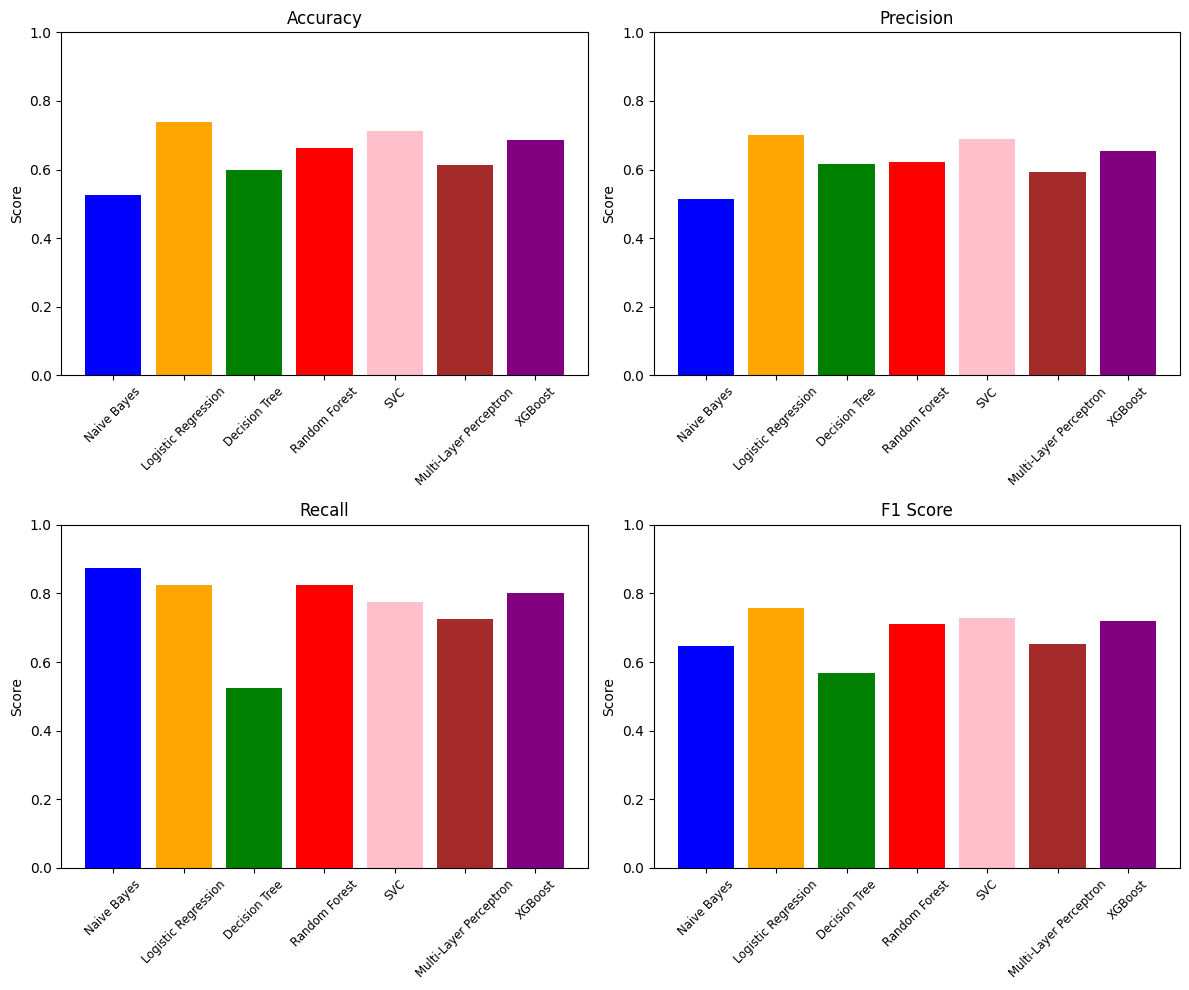

Classifier: Naive Bayes
Accuracy: 0.53
Precision: 0.51
Recall: 0.88
F1 Score: 0.65
------------------------------
Classifier: Logistic Regression
Accuracy: 0.74
Precision: 0.70
Recall: 0.82
F1 Score: 0.76
------------------------------
Classifier: Decision Tree
Accuracy: 0.60
Precision: 0.62
Recall: 0.53
F1 Score: 0.57
------------------------------
Classifier: Random Forest
Accuracy: 0.66
Precision: 0.62
Recall: 0.82
F1 Score: 0.71
------------------------------
Classifier: SVC
Accuracy: 0.71
Precision: 0.69
Recall: 0.78
F1 Score: 0.73
------------------------------
Classifier: Multi-Layer Perceptron
Accuracy: 0.61
Precision: 0.59
Recall: 0.72
F1 Score: 0.65
------------------------------
Classifier: XGBoost
Accuracy: 0.69
Precision: 0.65
Recall: 0.80
F1 Score: 0.72
------------------------------


In [87]:
import matplotlib.pyplot as plt

metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

colors = ["blue", "orange", "green", "red", "pink", "brown", "purple"]

for i, metric in enumerate(metrics_names):
    row = i // 2
    col = i % 2
    scores = [evaluation[i] for evaluation in evaluations.values()]
    axs[row, col].bar(classifiers.keys(), scores, color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel("Score")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].tick_params(axis="x", labelrotation=45, labelsize="small")

plt.tight_layout()
plt.show()

for classifier_name, metrics in evaluations.items():
    print(f"Classifier: {classifier_name}")
    print(f"Accuracy: {metrics[0]:.2f}")
    print(f"Precision: {metrics[1]:.2f}")
    print(f"Recall: {metrics[2]:.2f}")
    print(f"F1 Score: {metrics[3]:.2f}")
    print("-" * 30)

___

# Using Lexicons

We will use different general purpose lexicons, and leverage them to perform unsupervised sentiment analysis, and compare the results. Also, we will use a domain-specific [lexicon](https://sraf.nd.edu/loughranmcdonald-master-dictionary/).

The best performing one, will be used to create an extra feature to add to our data, and verify if it improves the traiend classifier models accuracy.

## VADER Sentiment

In [88]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

Use full_article field, which is a composition of the 3 article fields without applying preprocessing techniques.

In [89]:
vader_pred = []
for article in dataset["full_article"]:
    vader_pred.append(1 if analyzer.polarity_scores(article)['compound'] > 0 else 0)

In [90]:
print("Accuracy: ", accuracy_score(y, vader_pred))
print("Precision: ", precision_score(y, vader_pred))
print("Recall: ", recall_score(y, vader_pred))
print("F1: ", f1_score(y, vader_pred))

Accuracy:  0.595
Precision:  0.572972972972973
Recall:  0.9814814814814815
F1:  0.7235494880546075


## Afinn Sentiment

In [91]:
from afinn import Afinn

afn = Afinn()

In [92]:
scores = [afn.score(article) for article in dataset["full_article"]]
sentiment = [
    "positive" if score >= 0 else "negative"
    for score in scores
]

afinn_pred = []
for article in dataset["full_article"]:
    afinn_pred.append(1 if afn.score(article) > 0 else 0)

In [93]:
print("Accuracy: ", accuracy_score(y, afinn_pred))
print("Precision: ", precision_score(y, afinn_pred))
print("Recall: ", recall_score(y, afinn_pred))
print("F1: ", f1_score(y, afinn_pred))

Accuracy:  0.6025
Precision:  0.5785123966942148
Recall:  0.9722222222222222
F1:  0.7253886010362695


## SentiWordNet

In [94]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize

# nltk.download("sentiwordnet")
# nltk.download("wordnet")
# nltk.download("averaged_perceptron_tagger")


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wn.ADJ
    elif treebank_tag.startswith("V"):
        return wn.VERB
    elif treebank_tag.startswith("N"):
        return wn.NOUN
    elif treebank_tag.startswith("R"):
        return wn.ADV
    else:
        return None


def calculate_sentiment_score(text):
    sentiment_positive = 0.0
    sentiment_negative = 0.0
    article_count = 0

    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    for word, pos_tag in pos_tags:
        wordnet_pos = get_wordnet_pos(pos_tag)
        if wordnet_pos:
            synsets = wn.synsets(word, pos=wordnet_pos)
            if synsets:
                chosen_synset = synsets[0]
                senti_synset = swn.senti_synset(chosen_synset.name())
                sentiment_positive += senti_synset.pos_score()
                sentiment_negative += senti_synset.neg_score()
                article_count += 1

    if article_count > 0:
        final_sentiment = 1 if sentiment_positive > sentiment_negative else 0
    else:
        final_sentiment = None

    return final_sentiment


sentiwordnet_pred = []
for article in dataset["full_article"]:
    sentiment = calculate_sentiment_score(article)
    sentiwordnet_pred.append(sentiment)

In [95]:
print("Accuracy: ", accuracy_score(y, sentiwordnet_pred))
print("Precision: ", precision_score(y, sentiwordnet_pred))
print("Recall: ", recall_score(y, sentiwordnet_pred))
print("F1: ", f1_score(y, sentiwordnet_pred))

Accuracy:  0.6225
Precision:  0.6101694915254238
Recall:  0.8333333333333334
F1:  0.7045009784735812


## Loughran McDonald Master Dictionary

A domain-specific lexicon, altered to better fit the problem at hand (converted to a binary classification problem. Explained in [prepare_lexicon](data/prepare_lexicon.ipynb) notebook).

In [96]:
loughran_mcdonald = pd.read_csv("data/loughran-mcdonald-lexicon.csv")
loughran_mcdonald.head()

,Word,Sentiment
0,abandon,0
1,abandoned,0
2,abandoning,0
3,abandonment,0
4,abandonments,0


In [97]:
def calculate_sentiment_score(article, lexicon):
    words = article.lower().split()
    positive_score = 0
    negative_score = 0
    for word in words:
        if word in lexicon["Word"].values:
            sentiment = lexicon.loc[lexicon["Word"] == word, "Sentiment"].values[0]
            if sentiment == 1:
                positive_score += 1
            elif sentiment == 0:
                negative_score += 1
    if positive_score > negative_score:
        return 1 
    else:
        return 0  

In [98]:
loughran_mcdonald_preds = dataset["full_article"].apply(
    lambda x: calculate_sentiment_score(x, loughran_mcdonald)
)

In [99]:
print("Accuracy: ", accuracy_score(y, loughran_mcdonald_preds))
print("Precision: ", precision_score(y, loughran_mcdonald_preds))
print("Recall: ", recall_score(y, loughran_mcdonald_preds))
print("F1: ", f1_score(y, loughran_mcdonald_preds))

Accuracy:  0.5475
Precision:  0.7464788732394366
Recall:  0.24537037037037038
F1:  0.3693379790940767


Even tought this lexicon was domain specific, it probably wasn't comprehensive enough, or it didn't contain the key terms deemed necessary to accuratly predict sentiment.

___

As we can see, SentiWordNet was the best in classifying sentiment, lets use it to add labels to the dataset, and re-apply our classifier

In [100]:
dataset["sentiwordnet_pred"] = sentiwordnet_pred

In [101]:
sentiword_preds = np.array(dataset["sentiwordnet_pred"]).reshape(-1, 1)

Lets add the predictions a a new feature (column)

In [102]:
X2 = X.copy()
X2 = np.hstack((X2, sentiword_preds))

In [103]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y, test_size=0.2, random_state=42
)

print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

print("\nLabel distribution in the training set:")
print(y_train2.value_counts())

print("\nLabel distribution in the test set:")
print(y_test2.value_counts())

(320, 58852) (320,)
(80, 58852) (80,)

Label distribution in the training set:
Final Status
1    176
0    144
Name: count, dtype: int64

Label distribution in the test set:
Final Status
0    40
1    40
Name: count, dtype: int64


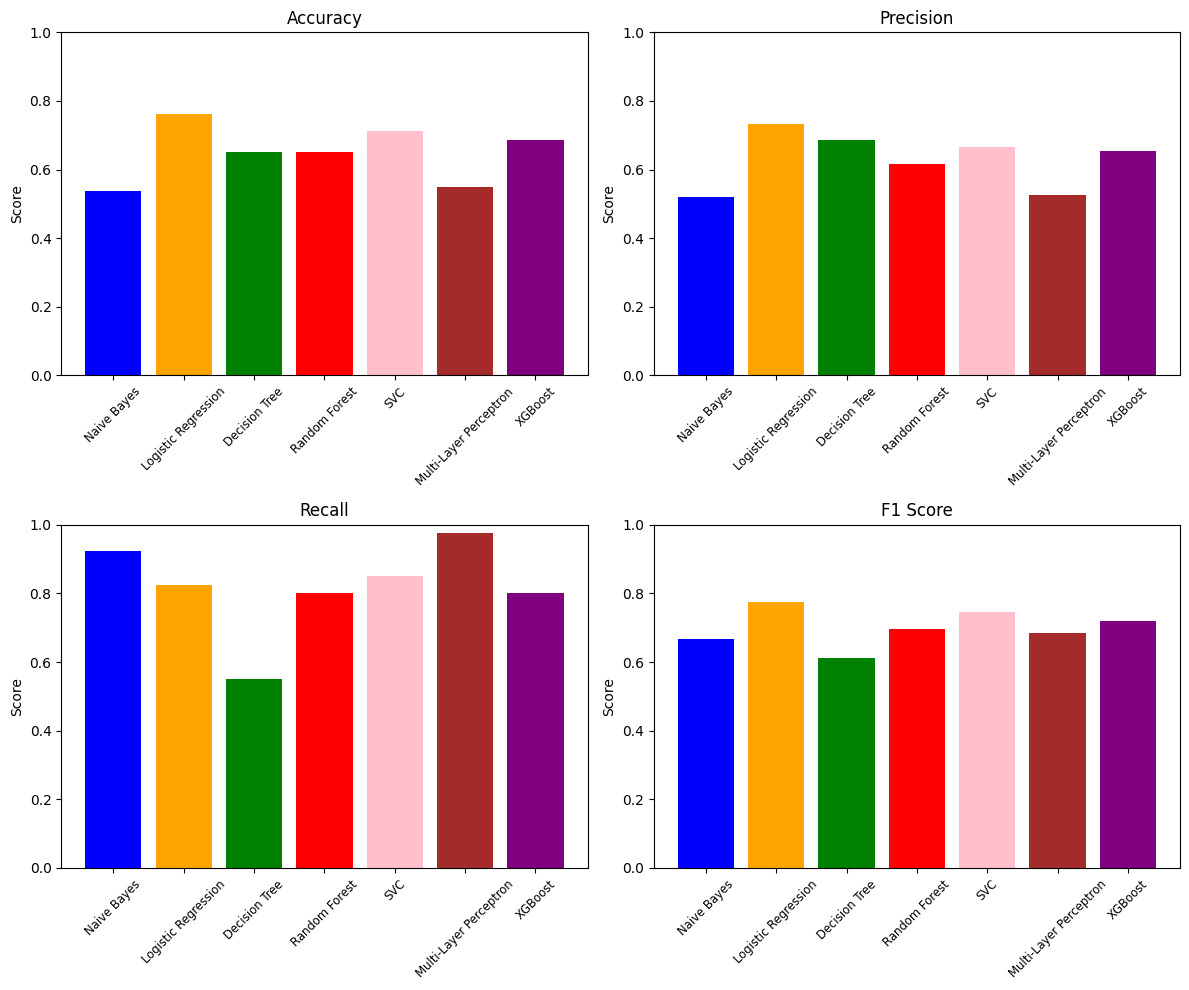

Classifier: Naive Bayes
Accuracy: 0.54
Precision: 0.52
Recall: 0.93
F1 Score: 0.67
------------------------------
Classifier: Logistic Regression
Accuracy: 0.76
Precision: 0.73
Recall: 0.82
F1 Score: 0.78
------------------------------
Classifier: Decision Tree
Accuracy: 0.65
Precision: 0.69
Recall: 0.55
F1 Score: 0.61
------------------------------
Classifier: Random Forest
Accuracy: 0.65
Precision: 0.62
Recall: 0.80
F1 Score: 0.70
------------------------------
Classifier: SVC
Accuracy: 0.71
Precision: 0.67
Recall: 0.85
F1 Score: 0.75
------------------------------
Classifier: Multi-Layer Perceptron
Accuracy: 0.55
Precision: 0.53
Recall: 0.97
F1 Score: 0.68
------------------------------
Classifier: XGBoost
Accuracy: 0.69
Precision: 0.65
Recall: 0.80
F1 Score: 0.72
------------------------------


In [104]:
evaluations2 = {
    classifier_name: evaluate_classifier(classifier, X_train2, y_train2, X_test2, y_test2)
    for classifier_name, classifier in classifiers_tuned.items()
}
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

colors = ["blue", "orange", "green", "red", "pink", "brown", "purple"]

for i, metric in enumerate(metrics_names):
    row = i // 2
    col = i % 2
    scores = [evaluation[i] for evaluation in evaluations2.values()]
    axs[row, col].bar(classifiers.keys(), scores, color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel("Score")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].tick_params(axis="x", labelrotation=45, labelsize="small")

plt.tight_layout()
plt.show()

for classifier_name, metrics in evaluations2.items():
    print(f"Classifier: {classifier_name}")
    print(f"Accuracy: {metrics[0]:.2f}")
    print(f"Precision: {metrics[1]:.2f}")
    print(f"Recall: {metrics[2]:.2f}")
    print(f"F1 Score: {metrics[3]:.2f}")
    print("-" * 30)

___

## Final Evaluation

In [105]:
max_name_length = max(len(name) for name in evaluations.keys() | evaluations2.keys())

print(
    f"{'Classifier Accuracy':<{max_name_length}} {'Base':<25} {'+Lexicon Features':<25}"
)
print("-" * (max_name_length + 60)) 

for classifier_name in sorted(set(evaluations.keys()) | set(evaluations2.keys())):
    accuracy_evaluations = evaluations.get(classifier_name, (0,))[0]
    accuracy_evaluations2 = evaluations2.get(classifier_name, (0,))[0]
    print(
        f"{classifier_name:<{max_name_length}} {accuracy_evaluations:.2f} {' ' * 10} {accuracy_evaluations2:.2f}"
    )

Classifier Accuracy    Base                      +Lexicon Features        
----------------------------------------------------------------------------------
Decision Tree          0.60            0.65
Logistic Regression    0.74            0.76
Multi-Layer Perceptron 0.61            0.55
Naive Bayes            0.53            0.54
Random Forest          0.66            0.65
SVC                    0.71            0.71
XGBoost                0.69            0.69


As we can see, using a Lexicon's sentiment predictions improved most of our classifiers, improving Logistic Regression even further!